# OpenAI Gym ~ HER problems (CartPole-v1)
- *Wheeler task definition ( task wrapper, State decoder settings, NeuralNetwork, ReplayBuffer, .. )*

### Import generics

In [1]:
import os, time

os.chdir("..")

import numpy as np
import toml, gym

import torch
from torch.multiprocessing import Queue, Process

### Prepare statistic helpers

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def print_stats(scores, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Rewards')
    plt.xlabel(title)
    plt.show()

### Load task configs ~ this should be adopted offline for particular task

In [3]:
CFG = toml.loads(open('cfg.toml').read())
GYM_CFG = toml.loads(open('gym.toml').read())

torch.set_default_tensor_type(CFG['tensor'])

CFG['task'] = "CartPole-v1"

### Import wheeler environment and particular utils we want to use ~ general ones ( shared across tasks )

In [4]:
from utils.task import Task
from utils.taskinfo import *

from utils.rbf import *
from utils.normalizer import *

from utils.taskmgr import *
from utils.replay import *

from utils.fastmem import Memory

from utils.curiosity import *

from agent.zer0bot import agent_launch

### Define Task wrapper ~ when is goal met, how to step ( update rewards function, .. ), when / how to reset

In [5]:
class GymTask(Task):
    def step_ex(self, action, test = False):
        action, a = self.softmax_policy(action, test)
        state, reward, done, _ = self.env.step(self.bot_id, self.objective_id, a)
        if done:
            reward = -40 * int(self.n_steps < self.cfg['max_n_episode'])#-40#
        if test: return action, [ state.reshape(-1) ], reward, done, True
        return action, state, reward, done, True

    def goal_met(self, states, rewards, n_steps):
        return sum(rewards) > 199 - 40

### Generic proxy for creating our Task ( multiprocess environments purpose mainly ) 
- but can also add wrapping function approx values ( action value to tanh, sigmoid, .. ) - this not works well with PPO now

In [6]:
class GymInfo(TaskInfo):
    def __init__(self, env, replaybuf, factory, Mgr, args):
        super().__init__(
                len(env.reset()), 2, -1, +2,
                CFG,
                replaybuf,
                factory, Mgr, args)

    def new(self, cfg, bot_id, objective_id):
        return GymTask(cfg,
                self.env,
                objective_id, bot_id,
                self.action_low, self.action_high)

    @staticmethod
    def factory(ind): # bare metal task creation
        global CFG
        print("created %i-th task"%ind)
        return gym.make(CFG['task'])

### Implement callback for testing policy ~ per X training rounds, we want to test it ~ enable visuals if you want

In [7]:
def context_callback(count, print_every):
    context_callback.z = 0
    context_callback.scores = []
    context_callback.total_scores = []
    def callback(task, agent, scores):
        context_callback.z += 1
        context_callback.total_scores += scores
        if 0 == context_callback.z % print_every:
            print("\nTEST review : ", np.mean(context_callback.scores[-print_every:]))
        # we can save scores to main queue, and avarage them, or we can ..
        # run testing w/ visuals :
        for _ in range(count):
            done, states, rewards = task.test_policy(agent)
            rewards = sum(rewards)
            context_callback.scores.append(rewards)            
            if not done:
                return None

        print("\n")
        print("="*80)
        print("training over", context_callback.z * GYM_CFG['n_simulations'] * GYM_CFG['mcts_rounds'])
        print("="*80)
        
        print_stats(context_callback.scores, "all-out::testing phase")

        return context_callback.total_scores
    return callback

### Prepare neural network which we will be using

In [8]:
from models import ddpg_model, noisy_model, state_action_model

def CriticNN(state_size, action_size, wrap_value, cfg):
    return state_action_model.Critic(state_size, action_size, wrap_value, cfg, fcs1_units=256, fc2_units=128)

def ActorNN(state_size, action_size, wrap_action, cfg):
    return noisy_model.Actor(state_size, action_size, wrap_action, cfg, hiddens=[64])
    return noisy_model.Actor(state_size, action_size, wrap_action, cfg, hiddens=[400, 300])
    return noisy_model.Actor(state_size, action_size, wrap_action, cfg, hiddens=[128, 64])

### Select encoders

In [9]:
from utils.encoders import *
from utils.rnn import *#GRUEncoder

def encoderstack(env):
    norm = GlobalNormalizer(GYM_CFG, len(env.reset()))
    return norm
    experience = GRUEncoder(GYM_CFG, norm.total_size())#GRU#LSTM
    encoder_norm = StackedEncoder(GYM_CFG, len(env.reset()), norm, experience)
    encoder_norm.share_memory()
    return encoder_norm

### Cook Task : replay buffer ( fast / prio-gae-rnn ) + task manager ( local / remote / unity )

In [10]:
def taskfactory(env):
    return GymInfo(env, Memory, GymInfo.factory, LocalTaskManager, ())
    return GymInfo(env, ReplayBuffer, GymInfo.factory, LocalTaskManager, ())
    return GymInfo(env, ReplayBuffer, GymInfo.factory, RemoteTaskManager, (LocalTaskManager, 1 + GYM_CFG['n_simulations']))

### Glue it all together ~ select buffer, encoders, agents, ... and RUN!!

{'tensor': 'torch.DoubleTensor', 'task': 'CartPole-v1', 'total_simulations': 2, 'cross_exp_size': 5000, 'max_reward_val': 1000, 'min_reward_val': -1000}
created 0-th task
created 1-th task
[0>  40::     0] training =  0, steps =  11, max_step =   9, reward=-30.000000 ::[[-1. -1.]]: TARGET:4.358505 replay::761 ]<------ay::615 ]<------
TEST review :  -19.8205128205
[0>  80::     0] training =  0, steps =  12, max_step =   8, reward=-29.000000 ::[[-1. -1.]]: TARGET:-0.346621 replay::1291 ]<-----
TEST review :  -25.975
[0> 120::     0] training =  0, steps =  14, max_step =   8, reward=-27.000000 ::[[-1. -1.]]: TARGET:6.344655 replay::1843 ]<------
TEST review :  -27.325
[0> 160::     0] training =  0, steps =  11, max_step =   8, reward=-30.000000 ::[[-1. -1.]]: 1.        ]]: 47 replay::2327 ]<-----y::2315 ]<------
TEST review :  -27.475
[0> 200::     0] training =  0, steps =  11, max_step =   8, reward=-30.000000 ::[[-1.  2.]]: TARGET:3.500250 replay::2922 ]<------lay::2662 ]<----
TEST 

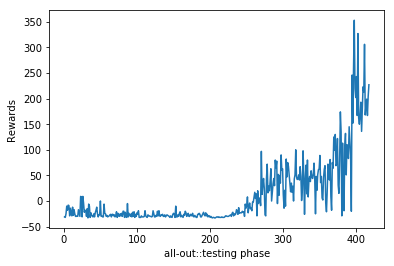

[0> 397::     0] training =  0, steps = 215, max_step =   8, reward=174.000000 ::[[ 2.  2.]]:   2.        ]]: [ TARGET:21.059059 replay::10000 ]<-----AGENT OVER
CRITIC OVER
SIMULATION OVER
FINISHED!


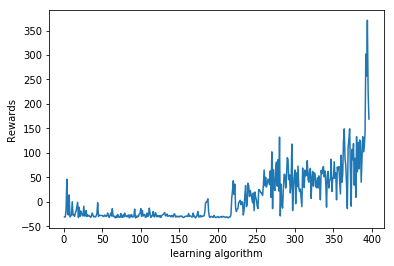

In [11]:
def main():
    print(CFG)

    env = gym.make(CFG['task'])
    
    encoder = encoderstack(env)
    task_factory = taskfactory(env)
    task = task_factory.new(GYM_CFG, 0, -1)
    
    callback = context_callback(10, 40)
    def callback_task(agent, stop_q):
        return callback(task, agent, stop_q)

    stop_q = Queue()
    agent_launch(0, GYM_CFG, task_factory, encoder, ActorNN, CriticNN, stop_q, callback_task)
    
    scores = stop_q.get()
    print("FINISHED!")
    print_stats(scores, "learning algorithm")

if '__main__' == __name__:
    main()